Day 6 -
Coxcomb chart (aka Nightingale rose chart), where:

Each wedge = a month

Each segment color = a continent

Radius = number of deaths

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
df = pd.read_csv("/content/gdrive/My Drive/owid-covid-data.csv")

In [23]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [27]:

# Filter out rows with missing data
df = df[df["continent"].notnull() & df["total_deaths"].notnull()].copy()

# Create a year-month column
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year_month"] = df["date"].dt.to_period("M")

# Compute monthly deaths per country
monthly_country = (
    df.groupby(["location", "continent", "year_month"])["total_deaths"]
    .max()
    .reset_index()
)

monthly_country["monthly_deaths"] = (
    monthly_country.groupby("location")["total_deaths"].diff().fillna(0)
)

# Group by continent and month
monthly_continent = (
    monthly_country.groupby(["continent", "year_month"])["monthly_deaths"]
    .sum()
    .reset_index()
)

# Convert period to timestamp

monthly_continent["year_month"] = monthly_continent["year_month"].dt.to_timestamp()


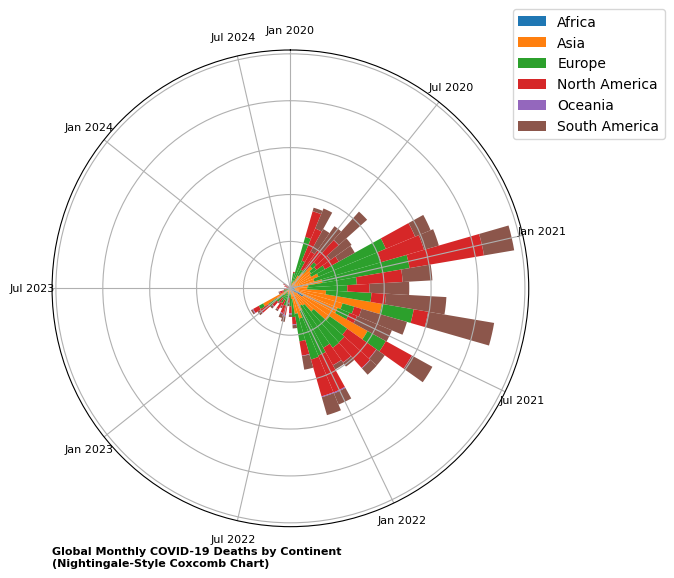

In [28]:

# Pivot data for stacked polar chart
pivot = monthly_continent.pivot(index="year_month", columns="continent", values="monthly_deaths").fillna(0)

# Sort columns to ensure consistent color ordering
pivot = pivot[sorted(pivot.columns)]

# Compute number of months and angle positions
num_months = len(pivot)
angles = np.linspace(0, 2 * np.pi, num_months, endpoint=False)

# Colors for continents
colors = {
    "Africa": "#1f77b4",
    "Asia": "#ff7f0e",
    "Europe": "#2ca02c",
    "North America": "#d62728",
    "Oceania": "#9467bd",
    "South America": "#8c564b"
}

# Create polar plot with adjusted size and title font
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True)) # Reduced figsize

# Stack continents one by one
bottom = np.zeros(num_months)
for continent in pivot.columns:
    values = pivot[continent].values
    ax.bar(angles, values, width=2*np.pi/num_months, bottom=bottom,
           label=continent, color=colors.get(continent, "#ccc"))
    bottom += values  # Stack the next layer on top


# Styling with modified title font size
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(angles[::6])
ax.set_xticklabels([d.strftime('%b %Y') for d in pivot.index[::6]], fontsize=8)
ax.set_yticklabels([])
ax.set_title("Global Monthly COVID-19 Deaths by Continent\n(Nightingale-Style Coxcomb Chart)", fontsize=8, weight='bold', loc='left', y=-0.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()
